In [104]:
import requests, re
from datetime import datetime, timedelta
import numpy as np, pandas as pd
import bs4
from bs4 import BeautifulSoup
from collections import namedtuple, defaultdict, deque
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt

In [105]:
url = "https://en.wikipedia.org/wiki/Timeline_of_Apple_Inc._products"
response = requests.get(url)

In [106]:
soup = BeautifulSoup(response.text, 'html.parser')

In [107]:
dat= soup.findAll('td')

In [108]:
r_year = re.compile("\d\d\d\d")
r_month_day = re.compile("((January)|(February)|(March)|(April)|(May)|(June)|(July)|(August)|(September)|(October)|(November)|December)\s\d+")
r_discontinued = re.compile("(\w+\s\d+,\s\d+)|(\d\d\d\d)|(((January)|(February)|(March)|(April)|(May)|(June)|(July)|(August)|(September)|(October)|(November)|December)\s\d+)|(current)")
# r_product = re.compile(r'(?<=\">)[a-zA-Z0-9 &;:\",.()$*\\]+?(?=\</a>)')   # '(?<=\">)[a-zA-Z0-9 &;:\",.()$*\\\\]+?(?=\</a>)'
# Product = namedtuple('Product', ['name', 'family', 'release_date', 'discontinued_date'])

In [109]:
# for row in dat[:100]:
#     text = row.text
#     print(f'{text = }')

In [110]:
head = list()
header = soup.findAll('table')[0].find('tr')
for item in header:
    if type(item) == bs4.element.Tag:
        head.append(item.text.strip())
head

['Year', 'Release Date', 'Model', 'Family', 'Discontinued']

In [111]:
num_table = 39
fam_of_interest = 'Mac Mini'
months = {
    'January':1,
    'February':2,
    'March':3,
    'April':4,
    'May':5,
    'June':6,
    'July':7,
    'August':8,
    'September':9,
    'October':10,
    'November':11,
    'December':12}

In [112]:
start_dat = soup.findAll('table')
dat = list()
for table in start_dat[:num_table]:
    table_dat = table.findAll('tr')[1:]
    for element in table_dat:
        sub = deque()
        for sub_element in element:
            if type(sub_element) == bs4.element.Tag:
                sub.append(sub_element.text.strip())
        while len(sub) < len(head):
            if r_year.match(sub[0]) == None:
                sub.appendleft(dat[-1][0])
                continue
            if sub[-1] != '' and r_discontinued.match(sub[-1]) == None:
                sub.append(dat[-1][-1])
                continue
            if r_month_day.match(sub[1]) == None:
                sub.insert(1, dat[-1][1])
                continue
            sub.insert(3, dat[-1][3])
        dat.append(sub)

In [113]:
for item in dat:
    year = item.popleft()
    rest = item.popleft()
    try:
        month, day = rest.split(' ')
    except:
        month = rest
        day = 15
    item.appendleft(datetime(int(year), months[month], int(day)))

In [114]:
header = ['Release Date']
header.extend(head[2:])
data = pd.DataFrame(data=dat, columns=header)
data.head()

,Release Date,Model,Family,Discontinued
0,1976-04-11,Apple I,Apple I,"September 1, 1977"
1,1977-04-01,Apple II,Apple II,"June 1, 1979"
2,1978-06-01,Disk II,Drives,"May 1, 1984"
3,1979-06-01,Apple II Plus,Apple II series,"December 1, 1982"
4,1979-06-01,Apple II EuroPlus,Apple II series,"December 1, 1982"


In [115]:
mac_mini = data[data['Family'] == fam_of_interest].copy()

In [116]:
mac_mini[['Release Date Shifted']] = mac_mini[['Release Date']].shift(periods=1)

In [117]:
mac_mini

,Release Date,Model,Family,Discontinued,Release Date Shifted
345,2005-01-11,Mac Mini,Mac Mini,"February 28, 2006",NaT
355,2006-02-28,Mac Mini Core Solo,Mac Mini,"September 6, 2006",2005-01-11
356,2006-02-28,Mac Mini Core Duo,Mac Mini,"August 7, 2007",2006-02-28
374,2007-08-07,Mac Mini (Mid 2007),Mac Mini,"March 3, 2009",2006-02-28
404,2009-03-03,Mac Mini (Early 2009),Mac Mini,"October 20, 2009",2007-08-07
424,2009-10-20,Mac Mini (Late 2009),Mac Mini,"June 15, 2010",2009-03-03
432,2010-06-15,Mac Mini (Mid 2010),Mac Mini,"July 20, 2011",2009-10-20
454,2011-07-20,Mac Mini (Mid 2011),Mac Mini,"October 23, 2012",2010-06-15
472,2012-10-23,Mac Mini (Late 2012),Mac Mini,"October 16, 2014",2011-07-20
513,2014-10-16,Mac Mini (Late 2014),Mac Mini,"October 30, 2018",2012-10-23


In [118]:
mac_mini[['Delay']] = mac_mini['Release Date'] - mac_mini['Release Date Shifted']
mac_mini[['Delay (s)']] = mac_mini['Delay'].dt.total_seconds()
mac_mini[['Release Date (ordinal)']] = mac_mini['Release Date'].apply(lambda x: x.toordinal())
mac_mini

,Release Date,Model,Family,Discontinued,Release Date Shifted,Delay,Delay (s),Release Date (ordinal)
345,2005-01-11,Mac Mini,Mac Mini,"February 28, 2006",NaT,NaT,NaN,731957
355,2006-02-28,Mac Mini Core Solo,Mac Mini,"September 6, 2006",2005-01-11,413 days,35683200.0,732370
356,2006-02-28,Mac Mini Core Duo,Mac Mini,"August 7, 2007",2006-02-28,0 days,0.0,732370
374,2007-08-07,Mac Mini (Mid 2007),Mac Mini,"March 3, 2009",2006-02-28,525 days,45360000.0,732895
404,2009-03-03,Mac Mini (Early 2009),Mac Mini,"October 20, 2009",2007-08-07,574 days,49593600.0,733469
424,2009-10-20,Mac Mini (Late 2009),Mac Mini,"June 15, 2010",2009-03-03,231 days,19958400.0,733700
432,2010-06-15,Mac Mini (Mid 2010),Mac Mini,"July 20, 2011",2009-10-20,238 days,20563200.0,733938
454,2011-07-20,Mac Mini (Mid 2011),Mac Mini,"October 23, 2012",2010-06-15,400 days,34560000.0,734338
472,2012-10-23,Mac Mini (Late 2012),Mac Mini,"October 16, 2014",2011-07-20,461 days,39830400.0,734799
513,2014-10-16,Mac Mini (Late 2014),Mac Mini,"October 30, 2018",2012-10-23,723 days,62467200.0,735522


In [119]:
mac_mini = mac_mini.drop([345,356,604,605])
mac_mini = mac_mini.reset_index()
mac_mini.pop('index')
mac_mini = mac_mini.reset_index()

In [120]:
mac_mini

,index,Release Date,Model,Family,Discontinued,Release Date Shifted,Delay,Delay (s),Release Date (ordinal)
0,0,2006-02-28,Mac Mini Core Solo,Mac Mini,"September 6, 2006",2005-01-11,413 days,35683200.0,732370
1,1,2007-08-07,Mac Mini (Mid 2007),Mac Mini,"March 3, 2009",2006-02-28,525 days,45360000.0,732895
2,2,2009-03-03,Mac Mini (Early 2009),Mac Mini,"October 20, 2009",2007-08-07,574 days,49593600.0,733469
3,3,2009-10-20,Mac Mini (Late 2009),Mac Mini,"June 15, 2010",2009-03-03,231 days,19958400.0,733700
4,4,2010-06-15,Mac Mini (Mid 2010),Mac Mini,"July 20, 2011",2009-10-20,238 days,20563200.0,733938
5,5,2011-07-20,Mac Mini (Mid 2011),Mac Mini,"October 23, 2012",2010-06-15,400 days,34560000.0,734338
6,6,2012-10-23,Mac Mini (Late 2012),Mac Mini,"October 16, 2014",2011-07-20,461 days,39830400.0,734799
7,7,2014-10-16,Mac Mini (Late 2014),Mac Mini,"October 30, 2018",2012-10-23,723 days,62467200.0,735522
8,8,2020-11-17,Mac Mini (2020),Mac Mini,current,2018-11-07,741 days,64022400.0,737746


In [122]:
lr = LinearRegression()
lr.fit(mac_mini[['index']], mac_mini[['Delay (s)']])

LinearRegression()

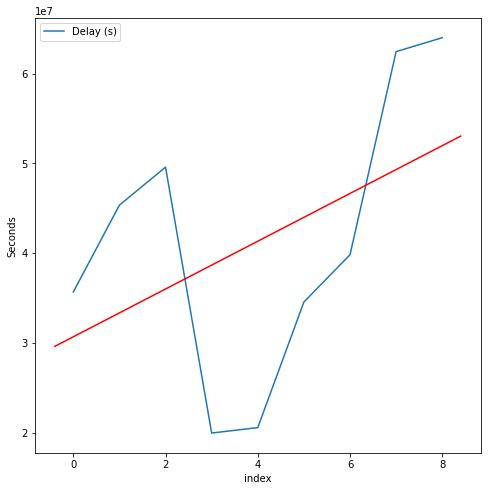

In [123]:
fig, ax = plt.subplots(figsize=(8,8))
mac_mini.plot('index', 'Delay (s)', ax=ax, ylabel='Seconds')
ax.plot(ax.get_xlim(), [lr.coef_[0][0]*ax.get_xlim()[0] + lr.intercept_[0], lr.coef_[0][0]*ax.get_xlim()[1] + lr.intercept_[0]], color='red')

In [124]:
mac_mini['Release Date'][8] + timedelta(seconds=lr.predict(np.arange(9,10).reshape(-1,1))[0][0])

Timestamp('2022-08-11 12:40:00')

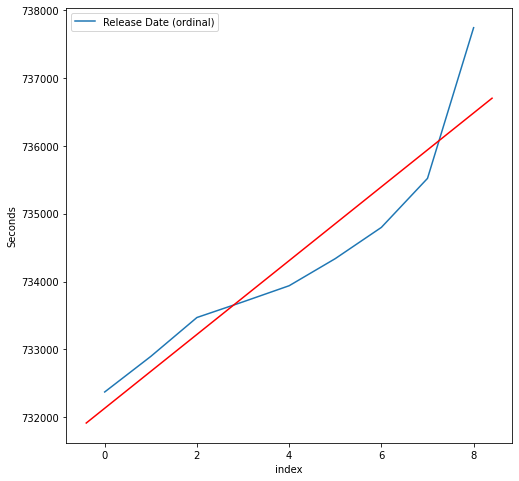

In [126]:
lr.fit(mac_mini[['index']], mac_mini[['Release Date (ordinal)']])
fig, ax = plt.subplots(figsize=(8,8))
mac_mini.plot('index', 'Release Date (ordinal)', ax=ax, ylabel='Seconds')
ax.plot(ax.get_xlim(), [lr.coef_[0][0]*ax.get_xlim()[0] + lr.intercept_[0], lr.coef_[0][0]*ax.get_xlim()[1] + lr.intercept_[0]], color='red')

In [127]:
datetime.fromordinal(int(lr.predict(np.arange(9,10).reshape(-1,1))[0][0]))

datetime.datetime(2018, 12, 4, 0, 0)

In [128]:
# train on each product individually???
# 